In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
import scipy

In [3]:
sales_df = pd.read_csv('./sales_cleaned.csv', index_col='index')
sales_df.head()

,Date,Year,Month,Customer Age,Customer Gender,Country,State,Product Category,Sub Category,Quantity,Unit Cost,Unit Price,Cost,Revenue,net_profit,Day,Month_numeric
index,,,,,,,,,,,,,,,,,
0,02/19/16,2016,February,29,F,United States,Washington,Accessories,Tires and Tubes,1.0,80.00,109.000000,80.0,109.0,29,19,2
1,02/20/16,2016,February,29,F,United States,Washington,Clothing,Gloves,2.0,24.50,28.500000,49.0,57.0,8,20,2
2,02/27/16,2016,February,29,F,United States,Washington,Accessories,Tires and Tubes,3.0,3.67,5.000000,11.0,15.0,4,27,2
3,03/12/16,2016,March,29,F,United States,Washington,Accessories,Tires and Tubes,2.0,87.50,116.500000,175.0,233.0,58,12,3
4,03/12/16,2016,March,29,F,United States,Washington,Accessories,Tires and Tubes,3.0,35.00,41.666667,105.0,125.0,20,12,3


In [4]:
sales_df.shape

(34866, 17)

In [5]:
sales_df.describe()

,Year,Customer Age,Quantity,Unit Cost,Unit Price,Cost,Revenue,net_profit,Day,Month_numeric
count,34866.000000,34866.000000,34866.000000,34866.000000,34866.000000,34866.000000,34866.000000,34866.000000,34866.000000,34866.000000
mean,2015.569237,36.382895,2.002524,349.880567,389.232485,576.004532,640.870074,64.865542,15.667671,6.317845
std,0.495190,11.112902,0.813936,490.015846,525.319091,690.500395,736.650597,152.879908,8.770677,3.465317
min,2015.000000,17.000000,1.000000,0.670000,0.666667,2.000000,2.000000,-937.000000,1.000000,1.000000
25%,2015.000000,28.000000,1.000000,45.000000,53.666667,85.000000,102.000000,5.000000,8.000000,3.000000
50%,2016.000000,35.000000,2.000000,150.000000,179.000000,261.000000,319.000000,27.000000,16.000000,6.000000
75%,2016.000000,44.000000,3.000000,455.000000,521.000000,769.000000,902.000000,96.000000,23.000000,9.000000
max,2016.000000,87.000000,3.000000,3240.000000,5082.000000,3600.000000,5082.000000,1842.000000,31.000000,12.000000


It appears that most of the distribution are a long tailed distribution, skewed to the lower end.

In [6]:
sales_df.duplicated().mean()

2.868123673492801e-05

In [7]:
sales_df[sales_df.duplicated(keep=False)].sort_values(['Date', 'Revenue'])

,Date,Year,Month,Customer Age,Customer Gender,Country,State,Product Category,Sub Category,Quantity,Unit Cost,Unit Price,Cost,Revenue,net_profit,Day,Month_numeric
index,,,,,,,,,,,,,,,,,
868,08/12/15,2015,August,43,F,Germany,Bayern,Accessories,Bottles and Cages,2.0,10.0,14.0,20.0,28.0,8,12,8
869,08/12/15,2015,August,43,F,Germany,Bayern,Accessories,Bottles and Cages,2.0,10.0,14.0,20.0,28.0,8,12,8


Out of 34866 entries, there was one entry that appears to be duplicated. It is quite possible that one person with the same demographic information purchased the exact same item on the same day. We will leave the duplicated entry as it is only one of them.

# Statistical tests

First, let's investigate the claim of gender having no relation with revenue generated

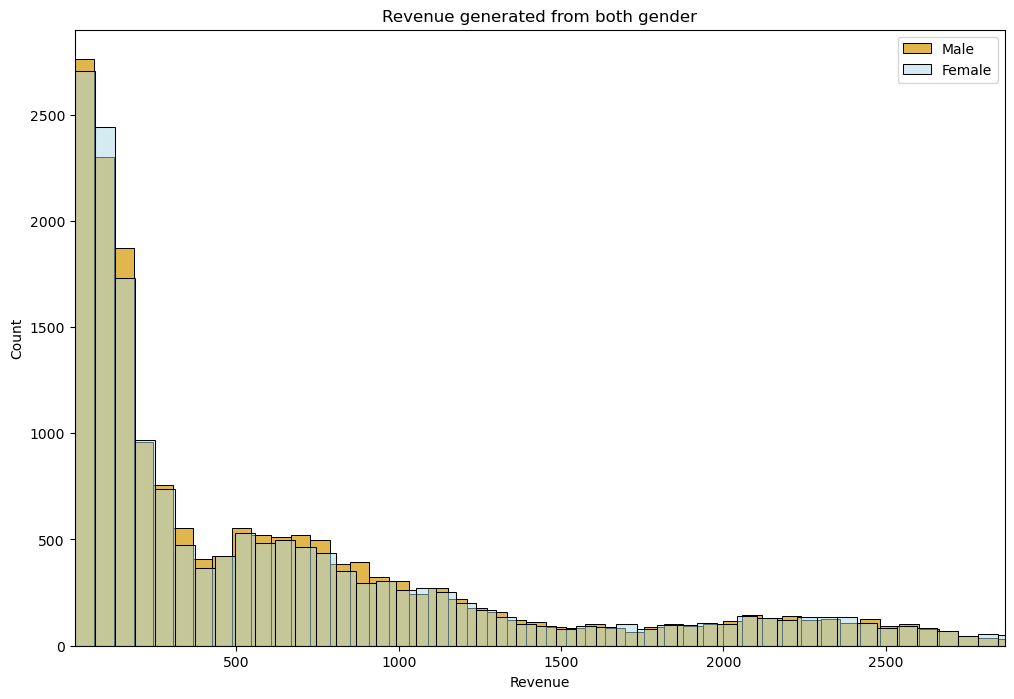

In [8]:
plt.figure(figsize = (12, 8))
sns.histplot(sales_df[sales_df['Customer Gender'] == 'M'].Revenue, 
                color='goldenrod', alpha = 0.8, label = 'Male')
sns.histplot(sales_df[sales_df['Customer Gender'] == 'F'].Revenue, 
                color='lightblue', alpha = 0.5, label = 'Female')
plt.xlim((sales_df['Revenue'].min(), sales_df['Revenue'].quantile(0.99)))
plt.title('Revenue generated from both gender')
plt.legend()
plt.show()

From the figure above, we can see that the two distributions from each gender are almost identical.

However, it apperas that the distributions consist of 3 difference distribution, with a right skewed, long tail distribution (likely to be from product sales with low pricing),
and 2 gaussian mixture distributions (centered at 600 and 2200)

In [9]:
sales_df['Product Category'].unique()

array(['Accessories', 'Clothing', 'Bikes'], dtype=object)

Coincidently, it apperas that we have exactly 3 different product categories. Let's investigate if these 3 product correspond to the 3 distributions we see.

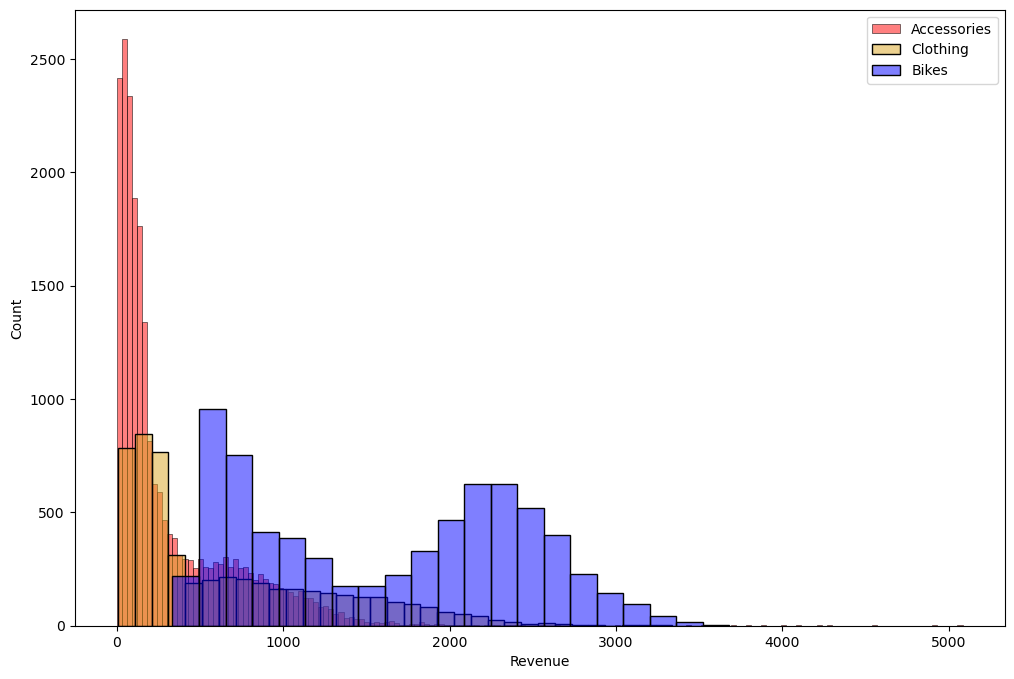

In [10]:
plt.figure(figsize=(12, 8))
for prod, color in zip(sales_df['Product Category'].unique(), ['red', 'goldenrod', 'blue']):
    sns.histplot(sales_df[sales_df['Product Category'] == prod]['Revenue'], 
    label = prod, color=color, alpha = 0.5)
plt.legend()
plt.show()

It appers that our guess was wrong, both accessories and cloting made up the right-skewed distribution, whereas the gaussian mixture distributin was from bikes category alone.

## T-test on revenues generated for different gender.

To determine if different gender had different spending habits, we will be running a unpaired t-test to investigate if the two distribution is the same.

The hypothesis of a unpaired t-test is as follows:
$$H_0: \bar{X} - \bar{Y} = 0$$
$$H_1: \bar{X} - \bar{Y} \neq 0$$

where X and Y are the two distribution compared.

In [11]:
ttest_stat, ttest_p = scipy.stats.ttest_ind(sales_df[sales_df['Customer Gender'] == 'M'].Revenue, 
                   sales_df[sales_df['Customer Gender'] == 'F'].Revenue )

print(f'The p-vale for unpaired t-test for both gender is {ttest_p:.4f}')

The p-vale for unpaired t-test for both gender is 0.9855


Indeed, we can see that the p-value is around 0.98, which is highly unlikely that the mean of revenue spent for each gender were different.

> However, from the distribution above, we can see that it is highly not normal. Although we do have 34688 entries, and the central limit theorem works in our favour, and the assumption of similar means from any sample drawn from the distribution is the same.

Just to be safe, we will be running a Wilcoxon test (alternative non-parametric t-test).

## Mann-whitney U test for revenues generated by eahc gender.

In [12]:
whitney_stat, whitney_p = scipy.stats.mannwhitneyu(sales_df[sales_df['Customer Gender'] == 'M'].Revenue, 
                   sales_df[sales_df['Customer Gender'] == 'F'].Revenue )

print(f'The p-vale for unpaired t-test for both gender is {whitney_p:.4f}')


The p-vale for unpaired t-test for both gender is 0.2144


### Conclusion
Indeed, from the p-value above, we can see that it is still higher than the threshold of 5%. 

>> There is no statistical significant that each gender had different spending habit!

# Relation between gender and product purchased

Now that we have determined that the amount spent had no relation to the gender of customers, let's investigate if there was any difference of product bought for each gender.

Let's look at the frequency table for product categories and gender.

In [13]:
gender_category_df = sales_df.groupby(['Customer Gender', 'Product Category'])['Product Category'] \
                        .count().unstack().T

gender_category_df

Customer Gender,F,M
Product Category,,
Accessories,11042,11492
Bikes,3514,3579
Clothing,2505,2734


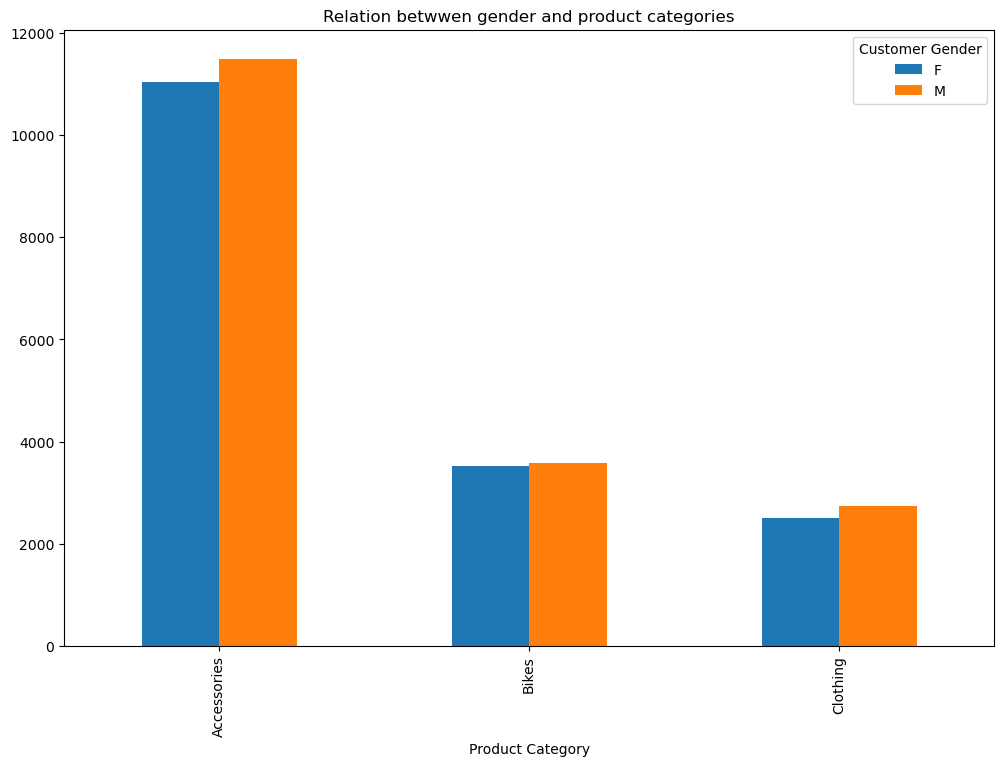

In [14]:
gender_category_df.plot(kind = 'bar', figsize=(12, 8))
plt.title('Relation betwwen gender and product categories')
plt.show()

From the table, we can see that for each product cetegory, the distribution was in a similar scale, with slightly more frequency for male's clothing transaction.

Although the numbers are quite similar, we still need to convert the corresponding chi2 statistic to our p-value of chi2 distribution, in this case, the degree of freedom (DOF) used will be the parameters in variable's number of categories:

$$
\begin{align}
DOF & = (\text{\# of product categories - 1}) \times (\text{\# of gender categories - 1})
\\
DOF & = 2
\end{align}
$$

We will be using scipy's chi2 test of independence for contigency tables. 

The hypothesis are as follows:

$$ H_0 = \text{The relation between variables are independent}$$
$$ H_1 = \text{The relation between batiables are not independent}$$

In [15]:
scipy.stats.chi2_contingency(gender_category_df)

Chi2ContingencyResult(statistic=3.7174085431453174, pvalue=0.15587447055732034, dof=2, expected_freq=array([[11026.57528825, 11507.42471175],
       [ 3470.82180348,  3622.17819652],
       [ 2563.60290828,  2675.39709172]]))

From the above result, we can see that the p-value is 0.1558, which we failed to reject the null hypothesis that gender is independent of product bought.

## Conclusion

>> There is no statistical significant proof that gender is related to product bought.

In [16]:
def chi2_test(df, col1, col2, show_table = True):
    assert col1 in df.columns and col2 in df.columns, 'Column names provide can not be found in dataframe!'
    _cont = df.groupby([col1, col2])[col2].count().unstack()
    _result = scipy.stats.chi2_contingency(_cont)
    if show_table:
        print('------------------------------')
        print('Observed contigency table')
        display(_cont)
        print('------------------------------')
        print('Expected frequency table')
        display(pd.DataFrame(_result[-1], index = _cont.index, 
                    columns = _cont.columns))
    print(f'The p-value of chi2 independence test is {_result[1]:.4f}')

In [17]:
chi2_test(sales_df, 'Country', 'Product Category')

------------------------------
Observed contigency table


Product Category,Accessories,Bikes,Clothing
Country,,,
France,3293,1152,723
Germany,3200,1291,710
United Kingdom,3986,1497,938
United States,12055,3153,2868


------------------------------
Expected frequency table


Product Category,Accessories,Bikes,Clothing
Country,,,
France,3340.093845,1051.357311,776.548844
Germany,3361.421844,1058.070699,781.507457
United Kingdom,4149.911490,1306.262634,964.825876
United States,11682.572822,3677.309356,2716.117823


The p-value of chi2 independence test is 0.0000


>> From the above result, we can see that there was deviation in sales, especially between United States with other countries. Infact, the corresponding p-value is 0, indicating there is a relation between the distribution of product sold and countries.

# Clustering analysis

After we have established that there are no interesting relation between the variables, let's dive deep into clustering analysis.

The aim of this section is to analyize customers behaviours, and determine if there are any groups with different spending habits, corresponding to different demographics.

In [18]:
sales_df.head()

,Date,Year,Month,Customer Age,Customer Gender,Country,State,Product Category,Sub Category,Quantity,Unit Cost,Unit Price,Cost,Revenue,net_profit,Day,Month_numeric
index,,,,,,,,,,,,,,,,,
0,02/19/16,2016,February,29,F,United States,Washington,Accessories,Tires and Tubes,1.0,80.00,109.000000,80.0,109.0,29,19,2
1,02/20/16,2016,February,29,F,United States,Washington,Clothing,Gloves,2.0,24.50,28.500000,49.0,57.0,8,20,2
2,02/27/16,2016,February,29,F,United States,Washington,Accessories,Tires and Tubes,3.0,3.67,5.000000,11.0,15.0,4,27,2
3,03/12/16,2016,March,29,F,United States,Washington,Accessories,Tires and Tubes,2.0,87.50,116.500000,175.0,233.0,58,12,3
4,03/12/16,2016,March,29,F,United States,Washington,Accessories,Tires and Tubes,3.0,35.00,41.666667,105.0,125.0,20,12,3


Before we can continue to our analysis, we have to preprocess several things, notice that we have several categorical categories:

In [19]:
sales_df.select_dtypes('object').columns

Index(['Date', 'Month', 'Customer Gender', 'Country', 'State',
       'Product Category', 'Sub Category'],
      dtype='object')

We will be excluding the Date and Month columns, as the purpose is not a time series analysis, and the categorical columns will be one-hot encoded, in order to be feed in to a clustering algorithm.

In [20]:
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

In [21]:
unwanted_col = ['Date', 'Year', 'Month', 'Quantity', 'Unit Cost', 'Unit Price', 'Day', 'Month_numeric', 
                    'Country', 'Product Category']
remaining_col = [x for x in list(sales_df.columns) if x not in unwanted_col]
remaining_col

['Customer Age',
 'Customer Gender',
 'State',
 'Sub Category',
 'Cost',
 'Revenue',
 'net_profit']

In [22]:
clustering_df = sales_df[remaining_col]

In [23]:
clustering_df.head()

,Customer Age,Customer Gender,State,Sub Category,Cost,Revenue,net_profit
index,,,,,,,
0,29,F,Washington,Tires and Tubes,80.0,109.0,29
1,29,F,Washington,Gloves,49.0,57.0,8
2,29,F,Washington,Tires and Tubes,11.0,15.0,4
3,29,F,Washington,Tires and Tubes,175.0,233.0,58
4,29,F,Washington,Tires and Tubes,105.0,125.0,20


In [24]:
ct = ColumnTransformer([('ohe', OneHotEncoder(), ['Customer Gender', 'State', 'Sub Category'])], 
                        # ('mmscaler', MinMaxScaler(), make_column_selector(dtype_include=['number', 'object']))],
                       remainder='passthrough', 
                       verbose_feature_names_out=False) 

In [25]:
pipe = Pipeline([('ohe', ct), 
                ('mascaler', MaxAbsScaler())])
                # ('clustering', DBSCAN())])

In [26]:
clustering_transformed = pipe.fit_transform(clustering_df)

In [27]:
clustering_tf_df = pd.DataFrame(clustering_transformed.toarray(), 
                                columns=pipe.get_feature_names_out())
clustering_tf_df

,Customer Gender_F,Customer Gender_M,State_Alabama,State_Arizona,State_Bayern,State_Brandenburg,State_California,State_Charente-Maritime,State_England,State_Essonne,...,Sub Category_Road Bikes,Sub Category_Shorts,Sub Category_Socks,Sub Category_Tires and Tubes,Sub Category_Touring Bikes,Sub Category_Vests,Customer Age,Cost,Revenue,net_profit
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.333333,0.022222,0.021448,0.015744
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.013611,0.011216,0.004343
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.333333,0.003056,0.002952,0.002172
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.333333,0.048611,0.045848,0.031488
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.333333,0.029167,0.024597,0.010858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34861,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.436782,0.569167,0.292601,-0.305103
34862,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.436782,0.644444,0.387839,-0.189468
34863,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.436782,0.569167,0.311492,-0.252986
34864,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.436782,0.569167,0.330972,-0.199240


In [28]:
dbs = DBSCAN()

dbs_result = dbs.fit(clustering_tf_df)


To determine if the clustering is a good representation, we will be using the silhouette_score from sklearn

In [29]:
silhouette_score(clustering_tf_df, dbs_result.labels_)

0.8095016500612702

## K-prototype clustering

In [30]:
from kmodes.kprototypes import KPrototypes

In [33]:
clustering_df.head()

,Customer Age,Customer Gender,State,Sub Category,Cost,Revenue,net_profit
index,,,,,,,
0,29,F,Washington,Tires and Tubes,80.0,109.0,29
1,29,F,Washington,Gloves,49.0,57.0,8
2,29,F,Washington,Tires and Tubes,11.0,15.0,4
3,29,F,Washington,Tires and Tubes,175.0,233.0,58
4,29,F,Washington,Tires and Tubes,105.0,125.0,20


In [56]:
numeric_scaler = ColumnTransformer([('std_scaler', StandardScaler(), 
                        make_column_selector(dtype_include='number'))], 
                        remainder = 'passthrough', 
                        verbose_feature_names_out=False)

clustering_scaled_df = pd.DataFrame(numeric_scaler.fit_transform(clustering_df),  
                                    columns = numeric_scaler.get_feature_names_out()).apply(lambda x: pd.to_numeric(x, errors='ignore'))

clustering_scaled_df


,Customer Age,Cost,Revenue,net_profit,Customer Gender,State,Sub Category
0,-0.664363,-0.718337,-0.722022,-0.234603,F,Washington,Tires and Tubes
1,-0.664363,-0.763232,-0.792612,-0.371968,F,Washington,Gloves
2,-0.664363,-0.818265,-0.849628,-0.398132,F,Washington,Tires and Tubes
3,-0.664363,-0.580753,-0.553690,-0.044909,F,Washington,Tires and Tubes
4,-0.664363,-0.682130,-0.700301,-0.293473,F,Washington,Tires and Tubes
...,...,...,...,...,...,...,...
34861,0.145518,2.133260,1.148634,-4.100438,M,Charente-Maritime,Mountain Bikes
34862,0.145518,2.525734,1.805672,-2.707167,M,Hauts de Seine,Mountain Bikes
34863,0.145518,2.133260,1.278956,-3.472485,M,Hauts de Seine,Mountain Bikes
34864,0.145518,2.133260,1.413350,-2.824908,M,Hauts de Seine,Mountain Bikes


In [57]:
clustering_scaled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34866 entries, 0 to 34865
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Customer Age     34866 non-null  float64
 1   Cost             34866 non-null  float64
 2   Revenue          34866 non-null  float64
 3   net_profit       34866 non-null  float64
 4   Customer Gender  34866 non-null  object 
 5   State            34866 non-null  object 
 6   Sub Category     34866 non-null  object 
dtypes: float64(4), object(3)
memory usage: 1.9+ MB


In [58]:
cat_position = [clustering_scaled_df.columns.get_loc(col) for col in 
                    clustering_scaled_df.select_dtypes('object').columns]
cat_position

[4, 5, 6]

In [59]:

clustering_scaled_df.select_dtypes('object').columns

Index(['Customer Gender', 'State', 'Sub Category'], dtype='object')

# Hyperparameter tuning

Now that we have demonstrated on how to perrrr

In [29]:
import optuna

In [30]:
def objective(trial):
    _epsilon = trial.suggest_float('_epsilon', 0.1, 4)
    _min_samples = trial.suggest_int('_min_samples', 5, 1000, log= True)
    _distance = trial.suggest_categorical('_distance', ['euclidean', 'manhattan'])
    _dbs = DBSCAN(eps=_epsilon, min_samples=_min_samples, metric=_distance)
    _dbs.fit(clustering_tf_df)
    try:
        return silhouette_score(clustering_tf_df, _dbs.labels_, metric=_distance, 
                                sample_size = clustering_tf_df.shape[0]*0.6, random_state = 42)
    except:
        return 0

In [31]:
clustering_tf_df.shape

(34866, 68)

In [36]:
dbs_dict = {'epsilon':[], 'min_sample':[], 'sil_score':[]}

for ep in np.linspace(0.1, 4, 20):
    for minsamp in np.logspace(5, 1000, 20):
        for _distance in ['euclidean', 'manhattan']:
            print(f'Fitting on epsion: {ep}, minimum_sample: {minsamp} with distance: {_distance}')
            _dbs = DBSCAN(eps=ep, min_samples=minsamp, metric=_distance)
            _dbs.fit(clustering_tf_df)
            dbs_dict['epsilon'].append(ep)
            dbs_dict['min_sample'].append(minsamp)
            try:
                sil_score = silhouette_score(clustering_tf_df, _dbs.labels_, metric=_distance, 
                                            sample_size = int(clustering_tf_df.shape[0]*0.6), random_state = 42)
            except:
                sil_score = 0
            dbs_dict['sil_score'].append(sil_socre)
            print(dbs_dict)


/home/shiya/anaconda3/lib/python3.9/site-packages/numpy/core/function_base.py:265: RuntimeWarning: overflow encountered in power
  return _nx.power(base, y)
/home/shiya/anaconda3/lib/python3.9/site-packages/numpy/core/function_base.py:265: RuntimeWarning: overflow encountered in power
  return _nx.power(base, y)
/home/shiya/anaconda3/lib/python3.9/site-packages/numpy/core/function_base.py:265: RuntimeWarning: overflow encountered in power
  return _nx.power(base, y)
/home/shiya/anaconda3/lib/python3.9/site-packages/numpy/core/function_base.py:265: RuntimeWarning: overflow encountered in power
  return _nx.power(base, y)
